In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
from __future__ import print_function
import os.path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enrich2.variant import WILD_TYPE_VARIANT
import enrich2.plots as enrich_plot
from functools import reduce

pd.set_option("display.max_rows", 20) # rows shown when pretty-printing
pd.set_option("display.max_columns", 100) # columns shown when pretty-printing

In [3]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

import statsmodels.api as sm
from patsy import dmatrices

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


## Import Dataframes

In [4]:
import math

Activity_without_Craf = pd.read_csv('Activity without CRAF_Replicate Score Data_filter 0.0000038_4BC minimum.tsv', sep='\t')
Activity_without_Craf = Activity_without_Craf[['Label', 'pERK/Flag, R1, WT normalized, Variant level', 'pERK/Flag, R2, WT normalized, Variant level', 'Average, Variant Level', 'Classification']]
for i, row in Activity_without_Craf.iterrows():
    if row['Classification'] == 'GOF':
        Activity_without_Craf.at[i, 'Classification'] = 'Activating'
    elif row['Classification'] == 'LOF':
        Activity_without_Craf.at[i, 'Classification'] = 'Inactivating'
    elif row['Classification'] == 'Wild Type-Like':
        Activity_without_Craf.at[i, 'Classification'] = 'Wild Type-Like'
        
Activity_with_Craf = pd.read_csv('Activity with CRAF_Replicate Score Data_filter 0.0000_3BC minimum.tsv', sep='\t')
for i, row in Activity_with_Craf.iterrows():
    if row['DMSO Classification'] == 'GOF':
        Activity_with_Craf.at[i, 'DMSO Classification'] = 'Activating'
    elif row['DMSO Classification'] == 'LOF':
        Activity_with_Craf.at[i, 'DMSO Classification'] = 'Inactivating'
    elif row['DMSO Classification'] == 'Wild Type-Like':
        Activity_with_Craf.at[i, 'DMSO Classification'] = 'Wild Type-Like'
        
Interactions_Craf = pd.read_csv('Interaction CRAF_Replicate Score Data_frequency 0.000003_3BC minimum.tsv', sep='\t')
for i, row in Interactions_Craf.iterrows():
    if row['DMSO Classification'] == 'GOF':
        Interactions_Craf.at[i, 'DMSO Classification'] = 'Increased Interaction'
    elif row['DMSO Classification'] == 'LOF':
        Interactions_Craf.at[i, 'DMSO Classification'] = 'Decreased Interaction'
    elif row['DMSO Classification'] == 'Wild Type-Like':
        Interactions_Craf.at[i, 'DMSO Classification'] = 'Wild Type-Like'
        
Interactions_MEK_250uM = pd.read_csv('Interaction MEK 250uM_Replicate Score Data_frequency 0.000004_4BC minimum.tsv', sep = '\t')
for i, row in Interactions_MEK_250uM.iterrows():
    if row['Classification'] == 'GOF':
        Interactions_MEK_250uM.at[i, 'Classification'] = 'Increased Interaction'
    elif row['Classification'] == 'LOF':
        Interactions_MEK_250uM.at[i, 'Classification'] = 'Decreased Interaction'
    elif row['Classification'] == 'Wild Type-Like':
        Interactions_MEK_250uM.at[i, 'Classification'] = 'Wild Type-Like'
        
Abundance = pd.read_csv('Abundance_Replicate Score Data_frequency 0.000016_3BC minimum.tsv', sep='\t')
for i, row in Abundance.iterrows():
    if row['Label'] == 'wild type':
        Abundance.at[i,'Label'] = '_wt'
        
Interactions_LXH_Craf = pd.read_csv('Interaction LXH Titration_Replicate Score Data_frequency 0.00000_5BC minimum.tsv', sep='\t')
for i, row in Interactions_LXH_Craf.iterrows():
    if row['DMSO Classification'] == 'GOF':
        Interactions_LXH_Craf.at[i, 'DMSO Classification'] = 'Increased Interaction'
    elif row['DMSO Classification'] == 'LOF':
        Interactions_LXH_Craf.at[i, 'DMSO Classification'] = 'Decreased Interaction'
    elif row['DMSO Classification'] == 'Wild Type-Like':
        Interactions_LXH_Craf.at[i, 'DMSO Classification'] = 'Wild Type-Like'

Activity_LXH_Craf = pd.read_csv('Activity LXH Titration_Replicate Score Data_filter 0.000005_5BC minimum.tsv', sep='\t')
Activity_LXH_Craf['Hill Slope'] = Activity_LXH_Craf['Hill Slope'].astype(object)
Activity_LXH_Craf['Top'] = Activity_LXH_Craf['Top'].astype(object)
Activity_LXH_Craf['Bottom'] = Activity_LXH_Craf['Bottom'].astype(object)
Activity_LXH_Craf['R-squared'] = Activity_LXH_Craf['R-squared'].astype(object)
for i, row in Activity_LXH_Craf.iterrows():
    if row['log(IC50)'] == 3.5:
        Activity_LXH_Craf.at[i, 'Hill Slope'] = 'ND (resistant)'
        Activity_LXH_Craf.at[i, 'Top'] = 'ND (resistant)'
        Activity_LXH_Craf.at[i, 'Bottom'] = 'ND (resistant)'
        Activity_LXH_Craf.at[i, 'R-squared'] = 'ND (resistant)'
    elif row['Activity Classification'] == 'Wild Type-Like':
        Activity_LXH_Craf.at[i, 'log(IC50)'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'Hill Slope'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'Top'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'Bottom'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'R-squared'] = 'ND (low activity)'        
    elif row['Activity Classification'] == 'LOF':
        Activity_LXH_Craf.at[i, 'log(IC50)'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'Hill Slope'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'Top'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'Bottom'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'R-squared'] = 'ND (low activity)'        
    elif row['log(IC50)'] == 'Undetermined (low activity)':
        Activity_LXH_Craf.at[i, 'log(IC50)'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'Hill Slope'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'Top'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'Bottom'] = 'ND (low activity)'
        Activity_LXH_Craf.at[i, 'R-squared'] = 'ND (low activity)'
    elif row['log(IC50)'] == 'Undetermined (RuntimeError)':
        Activity_LXH_Craf.at[i, 'log(IC50)'] = 'ND (RuntimeError)'
        Activity_LXH_Craf.at[i, 'Hill Slope'] = 'ND (RuntimeError)'
        Activity_LXH_Craf.at[i, 'Top'] = 'ND (RuntimeError)'
        Activity_LXH_Craf.at[i, 'Bottom'] = 'ND (RuntimeError)'
        Activity_LXH_Craf.at[i, 'R-squared'] = 'ND (RuntimeError)'
    elif row['log(IC50)'] == 'Undetermined (ValueError)':
        Activity_LXH_Craf.at[i, 'log(IC50)'] = 'ND (ValueError)'
        Activity_LXH_Craf.at[i, 'Hill Slope'] = 'ND (ValueError)'
        Activity_LXH_Craf.at[i, 'Top'] = 'ND (ValueError)'
        Activity_LXH_Craf.at[i, 'Bottom'] = 'ND (ValueError)'
        Activity_LXH_Craf.at[i, 'R-squared'] = 'ND (ValueError)'
    elif row['log(IC50)'] == 'Undetermined (OverflowError)':
        Activity_LXH_Craf.at[i, 'log(IC50)'] = 'ND (OverflowError)'
        Activity_LXH_Craf.at[i, 'Hill Slope'] = 'ND (OverflowError)'
        Activity_LXH_Craf.at[i, 'Top'] = 'ND (OverflowError)'
        Activity_LXH_Craf.at[i, 'Bottom'] = 'ND (OverflowError)'
        Activity_LXH_Craf.at[i, 'R-squared'] = 'ND (OverflowError)'
    elif row['Activity Classification'] == 'GOF':
        if row['R-squared'] > 0.6:
            continue
        elif math.isnan(row['R-squared']):
            continue
        else:
            Activity_LXH_Craf.at[i, 'log(IC50)'] = 'ND (R-squared < 0.6 or undetermined)'
            Activity_LXH_Craf.at[i, 'Hill Slope'] = 'ND (R-squared < 0.6 or undetermined)'
            Activity_LXH_Craf.at[i, 'Top'] = 'ND (R-squared < 0.6 or undetermined)'
            Activity_LXH_Craf.at[i, 'Bottom'] = 'ND (R-squared < 0.6 or undetermined)'
    else:
        Activity_LXH_Craf.at[i, 'log(IC50)'] = 'ND'
        Activity_LXH_Craf.at[i, 'Hill Slope'] = 'ND'
        Activity_LXH_Craf.at[i, 'Top'] = 'ND'
        Activity_LXH_Craf.at[i, 'Bottom'] = 'ND'
        Activity_LXH_Craf.at[i, 'R-squared'] = 'ND'
for i,row in Activity_LXH_Craf.iterrows():
    if row['Label'] == 'wild type':
        Activity_LXH_Craf.at[i, 'Label'] = '_wt'        
for i, row in Activity_LXH_Craf.iterrows():
    if row['Activity Classification'] == 'GOF':
        Activity_LXH_Craf.at[i, 'Activity Classification'] = 'Increased Activity'
    elif row['Activity Classification'] == 'LOF':
        Activity_LXH_Craf.at[i, 'Activity Classification'] = 'Decreased Activity'
    elif row['Activity Classification'] == 'Wild Type-Like':
        Activity_LXH_Craf.at[i, 'Activity Classification'] = 'Wild Type-Like'
        
SJF0628_Abundance = pd.read_csv('SJF0628_ReplicateScoreData.tsv', sep='\t')

#Merge all into single dataset
experiments = [Activity_without_Craf, Activity_with_Craf, Interactions_Craf, Interactions_MEK_250uM, Abundance, Interactions_LXH_Craf, Activity_LXH_Craf, SJF0628_Abundance]
data = reduce(lambda left, right: pd.merge(left, right, on='Label', how='outer'), experiments)

#Rename the columns
new_column_names = ['Label', 
                    'Score, Replicate 1', 'Score, Replicate 2', 'Mean Score, Activity without CRaf', 'Activity (without CRaf) Classification',
                    'Score, Replicate 1', 'Score, Replicate 2', 'Mean Score, Activity with CRaf', 'Activity_with_CRaf_Classification',
                    'Score, Replicate 1', 'Score, Replicate 2', 'Mean Score, CRaf Interaction', 'CRaf Interaction Classification', 'Vemurafenib Mean Score, CRaf Interaction', 'LXH Mean Score, CRaf Interaction',
                    'Score, Replicate 1', 'Score, Replicate 2', 'Mean Score, Mek Interaction', 'Mek_Interaction_Classification',
                    'Score, Replicate 1', 'Score, Replicate 2', 'Mean Score, Abundance',
                    '3uM Mean Score', '1uM Mean Score', '333nM Mean Score', '111nM Mean Score', '37nM Mean Score', 'DMSO Mean Score', 
                    '3uM Score, Replicate 1', '1uM Score, Replicate 1', '333nM Score, Replicate 1', '111nM Score, Replicate 1', '37nM Score, Replicate 1', 'DMSO Score, Replicate 1',
                    '3uM Score, Replicate 2', '1uM Score, Replicate 2', '333nM Score, Replicate 2', '111nM Score, Replicate 2', '37nM Score, Replicate 2', 'DMSO Score, Replicate 2',
                    '3uM/DMSO Score', '1uM/DMSO Score', '333nM/DMSO Score', '111nM/DMSO Score', '37nM/DMSO Score',
                    'DMSO Mean Score', 'DMSO Score, Replicate 1', 'DMSO Score, Replicate 2', 'DMSO Classification', 'log(DC50)', 'Hill Slope', 'Top', 'Bottom', 'DC50 R-squared', 'StDev log(DC50)', ''
                    '3uM Mean Score', '1uM Mean Score', '333nM Mean Score', '111nM Mean Score', '37nM Mean Score', 'DMSO Mean Score', 
                    '3uM Score, Replicate 1', '1uM Score, Replicate 1', '333nM Score, Replicate 1', '111nM Score, Replicate 1', '37nM Score, Replicate 1', 'DMSO Score, Replicate 1',
                    '3uM Score, Replicate 2', '1uM Score, Replicate 2', '333nM Score, Replicate 2', '111nM Score, Replicate 2', '37nM Score, Replicate 2', 'DMSO Score, Replicate 2',
                    '3uM/DMSO Score', '1uM/DMSO Score', '333nM/DMSO Score', '111nM/DMSO Score', '37nM/DMSO Score', 'DMSO/DMSO Score',
                    'Mean DMSO Score', 'DMSO Classification', 'log(IC50)', 'Hill Slope', 'Top', 'Bottom', 'R-squared',
                    'Abundance at 2.5uM SJF0628',
                    'Position', 'Mutation',
                   ]

data.columns = new_column_names

data.to_csv('Summary Table.tsv', sep='\t') 

data     

,Label,"Score, Replicate 1","Score, Replicate 2","Mean Score, Activity without CRaf",Activity (without CRaf) Classification,"Score, Replicate 1","Score, Replicate 2","Mean Score, Activity with CRaf",Activity_with_CRaf_Classification,"Score, Replicate 1","Score, Replicate 2","Mean Score, CRaf Interaction",CRaf Interaction Classification,"Vemurafenib Mean Score, CRaf Interaction","LXH Mean Score, CRaf Interaction","Score, Replicate 1","Score, Replicate 2","Mean Score, Mek Interaction",Mek_Interaction_Classification,"Score, Replicate 1","Score, Replicate 2","Mean Score, Abundance",3uM Mean Score,1uM Mean Score,333nM Mean Score,111nM Mean Score,37nM Mean Score,DMSO Mean Score,"3uM Score, Replicate 1","1uM Score, Replicate 1","333nM Score, Replicate 1","111nM Score, Replicate 1","37nM Score, Replicate 1","DMSO Score, Replicate 1","3uM Score, Replicate 2","1uM Score, Replicate 2","333nM Score, Replicate 2","111nM Score, Replicate 2","37nM Score, Replicate 2","DMSO Score, Replicate 2",3uM/DMSO Score,1uM/DMSO Score,333nM/DMSO Score,111nM/DMSO Score,37nM/DMSO Score,DMSO Mean Score,"DMSO Score, Replicate 1","DMSO Score, Replicate 2",DMSO Classification,log(DC50),Hill Slope,Top,Bottom,DC50 R-squared,StDev log(DC50),3uM Mean Score,1uM Mean Score,333nM Mean Score,111nM Mean Score,37nM Mean Score,DMSO Mean Score,"3uM Score, Replicate 1","1uM Score, Replicate 1","333nM Score, Replicate 1","111nM Score, Replicate 1","37nM Score, Replicate 1","DMSO Score, Replicate 1","3uM Score, Replicate 2","1uM Score, Replicate 2","333nM Score, Replicate 2","111nM Score, Replicate 2","37nM Score, Replicate 2","DMSO Score, Replicate 2",3uM/DMSO Score,1uM/DMSO Score,333nM/DMSO Score,111nM/DMSO Score,37nM/DMSO Score,DMSO/DMSO Score,Mean DMSO Score,DMSO Classification,log(IC50),Hill Slope,Top,Bottom,R-squared,Abundance at 2.5uM SJF0628,Position,Mutation
0,Ala305Asn,1.046600,0.838108,0.942354,Wild Type-Like,1.070176,0.861774,0.965975,Wild Type-Like,0.966411,1.074007,1.020209,Wild Type-Like,0.996586,0.998985,0.909121,1.044406,0.976763,Wild Type-Like,1.020324,1.063061,0.965658,1.273579,1.209297,0.857774,0.728307,0.508963,0.318292,1.215805,1.151496,0.967648,0.640950,0.584877,0.321459,1.331353,1.267099,0.747900,0.815665,0.433050,0.315125,4.108723,3.898982,2.771665,2.345710,1.631625,0.958432,0.925241,0.991622,Wild Type-Like,2.4302309139826357,0.7649315902626503,1.454161238802605,0.30583945517762895,0.942835,0.292438,0.142526,0.197649,0.126852,0.320731,0.391706,0.183873,0.248778,0.195199,-0.000352,0.453205,0.422497,0.187964,0.099195,0.200099,0.254055,0.188257,0.315162,0.179782,0.672115,-0.159879,1.062833,0.591273,1.165232,1.0,1.110607,Wild Type-Like,ND (low activity),ND (low activity),ND (low activity),ND (low activity),ND (low activity),-0.044885,305,Asn
1,Ala305Gln,1.298219,1.130916,1.214567,Wild Type-Like,1.326459,1.119227,1.222843,Activating,1.037706,1.207888,1.122797,Increased Interaction,1.025135,1.078094,1.035300,0.958160,0.996730,Wild Type-Like,0.989324,1.030807,0.951559,1.283124,1.170756,0.864649,0.707302,0.501615,0.323083,1.211951,1.095864,0.971239,0.679039,0.517641,0.346281,1.354297,1.245649,0.758058,0.735565,0.485589,0.299886,4.171765,3.799670,2.814114,2.272231,1.594361,0.970176,0.996685,0.943667,Wild Type-Like,2.4896871014460236,0.7466857185016237,1.4770039527533183,0.3084177929408283,0.961372,0.263515,0.080550,0.127095,0.301858,0.191557,0.183321,0.141114,0.071989,0.150074,0.468487,0.123425,0.377834,0.187373,0.089110,0.104115,0.135229,0.192280,-0.011191,0.094856,1.085609,1.659596,2.608639,0.224466,0.444375,1.0,1.047287,Wild Type-Like,ND (low activity),ND (low activity),ND (low activity),ND (low activity),ND (low activity),-0.042764,305,Gln
2,Ala305Ile,1.196038,0.896572,1.046305,Wild Type-Like,1.172525,1.152691,1.162608,Wild Type-Like,0.917772,0.947632,0.932702,Wild Type-Like,0.963362,0.909265,1.052564,1.034160,1.043362,Wild Type-Like,1.005752,1.028091,1.005977,1.260683,1.249150,0.909685,0.760443,0.472572,0.316991,1.211514,1.208035,1.117080,0.707967,0.5347

# Clustering Dataframe

In [19]:
pd.set_option("display.max_rows", 20)

clustering_data = data[['Label', 'Position', 'Mutation', 'Mean Score, Activity without CRaf', 'Mean Score, Activity with CRaf', 'Mean Score, CRaf Interaction', 
                        #'Vemurafenib Mean Score, CRaf Interaction',
                        #'LXH Mean Score, CRaf Interaction', 
                        'Mean Score, Mek Interaction', 
                        #'Abundance at 2.5uM SJF0628',
                        'Mek_Interaction_Classification', 
                        'Mean Score, Abundance']]

clustering_data.columns=['Label', 'Position', 'Mutation', 'Activity_without_Craf', 'Activity_Craf', 'Interaction_Craf', 
                         #'Vemurafenib_CRaf_Interaction', 
                         #'LXH_CRaf_Interaction', 
                         'Interaction_Mek', 
                         #'Abundance at 2.5uM SJF0628', 
                         'Mek_Interaction_Classification', 
                         'Mean Score, Abundance']

clustering_data = clustering_data.set_index('Label')
clustering_data =clustering_data[clustering_data['Mutation'] != 'Ter']

clustering_data['delta_score'] = clustering_data['Activity_without_Craf'] - clustering_data['Activity_Craf']

#Calculate zscores

mean = clustering_data['Activity_without_Craf'].mean()
std = clustering_data['Activity_without_Craf'].std()
clustering_data['Activity_without_Craf_zscore'] = (clustering_data['Activity_without_Craf'] - mean)/std

mean = clustering_data['Activity_Craf'].mean()
std = clustering_data['Activity_Craf'].std()
clustering_data['Activity_Craf_zscore'] = (clustering_data['Activity_Craf'] - mean)/std

mean = clustering_data['Interaction_Craf'].mean()
std = clustering_data['Interaction_Craf'].std()
clustering_data['Interaction_Craf_zscore'] = (clustering_data['Interaction_Craf'] - mean)/std

#mean = clustering_data['Vemurafenib_CRaf_Interaction'].mean()
#std = clustering_data['Vemurafenib_CRaf_Interaction'].std()
#clustering_data['Vemurafenib_CRaf_Interaction_zscore'] = (clustering_data['Vemurafenib_CRaf_Interaction'] - mean)/std

#mean = clustering_data['LXH_CRaf_Interaction'].mean()
#std = clustering_data['LXH_CRaf_Interaction'].std()
#clustering_data['LXH_CRaf_Interaction_zscore'] = (clustering_data['LXH_CRaf_Interaction'] - mean)/std

mean = clustering_data['Interaction_Mek'].mean()
std = clustering_data['Interaction_Mek'].std()
clustering_data['Interaction_Mek_zscore'] = (clustering_data['Interaction_Mek'] - mean)/std

#mean = clustering_data['Abundance at 2.5uM SJF0628'].mean()
#std = clustering_data['Abundance at 2.5uM SJF0628'].std()
#clustering_data['Abundance at 2.5uM SJF0628_zscore'] = (clustering_data['Abundance at 2.5uM SJF0628'] - mean)/std

mean = clustering_data['delta_score'].mean()
std = clustering_data['delta_score'].std()
clustering_data['delta_score_zscore'] = (clustering_data['delta_score'] - mean)/std

mean = clustering_data['Mean Score, Abundance'].mean()
std = clustering_data['Mean Score, Abundance'].std()
clustering_data['Mean Score, Abundance_zscore'] = (clustering_data['Mean Score, Abundance'] - mean)/std

#Make sure to remove lines with missing data! If you don't, you'll get weird groups
clustering_data = clustering_data.dropna()

clustering_data



,Position,Mutation,Activity_without_Craf,Activity_Craf,Interaction_Craf,Interaction_Mek,Mek_Interaction_Classification,"Mean Score, Abundance",delta_score,Activity_without_Craf_zscore,Activity_Craf_zscore,Interaction_Craf_zscore,Interaction_Mek_zscore,delta_score_zscore,"Mean Score, Abundance_zscore"
Label,,,,,,,,,,,,,,,
Ala305Asn,305,Asn,0.942354,0.965975,1.020209,0.976763,Wild Type-Like,0.965658,-0.023621,-0.672798,-0.754270,-0.533872,0.324891,0.072163,-0.155961
Ala305Gln,305,Gln,1.214567,1.222843,1.122797,0.996730,Wild Type-Like,0.951559,-0.008276,0.105649,0.040740,-0.429901,0.413640,0.162399,-0.256540
Ala305Ile,305,Ile,1.046305,1.162608,0.932702,1.043362,Wild Type-Like,1.005977,-0.116303,-0.375531,-0.145688,-0.622558,0.620906,-0.472854,0.131657
Ala305Leu,305,Leu,1.024784,0.818469,1.007082,1.004205,Wild Type-Like,0.994512,0.206315,-0.437074,-1.210803,-0.547175,0.446865,1.424293,0.049870
Ala305Lys,305,Lys,0.913186,1.087868,1.064671,1.001175,Wild Type-Like,1.059508,-0.174682,-0.756210,-0.377009,-0.488810,0.433394,-0.816148,0.513525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Val600Pro,600,Pro,2.132742,2.081816,1.611030,0.580433,Decreased Interaction,1.004733,0.050926,2.731349,2.699273,0.064913,-1.436702,0.510533,0.122782
Val600Ser,600,Ser,1.778219,1.823215,1.855834,0.699115,Decreased Interaction,1.114764,-0.044995,1.717522,1.898897,0.313016,-0.909189,-0.053528,0.907698
Val600Thr,600,Thr,1.905253,1.965707,1.768567,0.741565,Decreased Interaction,1.024427,-0.060453,2.080800,2.339912,0.224573,-0.720509,-0.144430,0.263272


In [20]:
#Define the dataset
clustering_data_by_position = clustering_data.groupby(['Position'])[
                                                                    #'delta_score',
                                                                    #'Abundance at 2.5uM SJF0628',
                                                                    #'log(DC50)'
                                                                    #'Activity_without_Craf_zscore', 
                                                                    'Activity_Craf_zscore', 
                                                                    'Interaction_Craf_zscore', 
                                                                    'Interaction_Mek_zscore', 
                                                                    'delta_score_zscore',
                                                                    'Mean Score, Abundance_zscore',
                                                                    #'log(DC50)_zscore',
                                                                    #'Vemurafenib_CRaf_Interaction_zscore',
                                                                    #'LXH_CRaf_Interaction_zscore'
                                                                   ].mean().reset_index()

#Remove scores you don't need
clustering_data_zscores_only = clustering_data[['Position', 'Mutation', 
                                                #'Activity_without_Craf_zscore', 
                                                'Activity_Craf_zscore', 
                                                'delta_score_zscore',
                                                'Interaction_Craf_zscore',
                                                'Interaction_Mek_zscore',
                                                'Mean Score, Abundance_zscore', 
                                                #'log(DC50)_zscore',
                                                #'Vemurafenib_CRaf_Interaction_zscore',
                                                #'LXH_CRaf_Interaction_zscore'
                                               ]]

clustering_data_zscores_only = clustering_data_zscores_only.dropna()


clustering_data_zscores_only = clustering_data_zscores_only.pivot_table(index='Position', columns='Mutation', values=['Interaction_Craf_zscore',
                                                                                                                      'Interaction_Mek_zscore',
                                                                                                                      'Activity_Craf_zscore', 
                                                                                                                      #'Activity_without_Craf_zscore', 
                                                                                                                      'delta_score_zscore', 
                                                                                                                      'Mean Score, Abundance_zscore', 
                                                                                                                      #'log(DC50)_zscore', 
                                                                                                                      #'Vemurafenib_CRaf_Interaction_zscore',
                                                                                                                      #'LXH_CRaf_Interaction_zscore',
                                                                                                                     ])

clustering_data_zscores_only = clustering_data_zscores_only.reset_index()
clustering_data_zscores_only

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


Position Activity_Craf_zscore                                \
Mutation                           Ala       Arg       Asn       Asp   
0             102            -0.519944       NaN -0.808247 -0.961000   
1             189                  NaN       NaN -1.077833  0.137185   
2             192                  NaN       NaN       NaN -0.343875   
3             211             0.415754 -0.360173       NaN       NaN   
4             257            -0.529590  1.305807 -1.015974       NaN   
..            ...                  ...       ...       ...       ...   
74            726            -0.688493       NaN -0.811387 -1.153957   
75            727            -0.882281  1.182278 -1.221622 -1.126786   
76            735             0.036678       NaN  0.319028 -0.374534   
77            762                  NaN  0.030541 -0.792147 -0.131409   
78             80            -1.052331 -0.064051 -0.548431 -0.253652   

                                                                      \
Mutation       Cys       Gln       Glu       Gly       His       Ile   
0        -0.647887 -0.793387       NaN       NaN -0.659933       NaN   
1              NaN       NaN -0.849172       NaN       NaN       NaN   
2        -0.645661       NaN  0.108529       NaN       NaN       NaN   
3              NaN       NaN -0.837662 -1.200616 -0.401567  1.151309   
4         0.347437       NaN -0.120944 -0.200888 -0.392468  1.244272   
..             ...       ...       ...       ...       ...       ...   
74       -1.029102 -0.707751 -0.692318 -0.662802 -0.644262 -1.088438   
75       -1.021581 -0.714957 -1.025262 -1.139391 -1.030388 -0.861344   
76       -0.145387  0.254302  0.351243  0.675650 -0.575057  0.282327   
77       -0.200839 -0.315246 -0.192950 -0.257525 -0.406375 -0.436926   
78             NaN -0.522553       NaN       NaN -0.149306 -0.800132   

                                                                      \
Mutation       Leu       Lys       Met       Phe       Pro       Ser   
0              NaN -0.917379 -0.340840 -1.073331 -0.370868       NaN   
1        -1.762827       NaN       NaN       NaN       NaN -0.599922   
2        -1.289114       NaN       NaN       NaN       NaN -0.172867   
3        -1.132785       NaN -0.253302 -0.397207       NaN -0.662701   
4              NaN       NaN       NaN  0.250061  1.244829 -0.655401   
..             ...       ...       ...       ...       ...       ...   
74       -1.472494 -0.518122 -0.922441 -0.889395       NaN -0.157507   
75       -1.006598 -0.942140 -0.996848 -0.775971 -1.365833       NaN   
76       -0.097380  0.728084 -0.706312  0.127261 -0.045363  0.652546   
77       -0.808416 -0.512950 -0.762156 -0.231872 -0.002836 -0.533591   
78             NaN       NaN  0.426046       NaN -0.773405       NaN   

                                                 Interaction_Craf_zscore  \
Mutation       Thr       Trp       Tyr       Val                     Ala   
0              NaN -0.900097 -0.186776 -0.690320               -0.530468   
1              NaN -1.288853  0.169099       NaN                     NaN   
2              NaN -0.602557       NaN       NaN                     NaN   
3              NaN       NaN -0.845401       NaN               -0.365681   
4        -0.791513  1.019307 -0.370309  0.268498               -0.806949   
..             ...       ...       ...       ...                     ...   
74       -0.656973 -1.354354 -1.017096 -0.709206               -0.307964   
75        0.739086 -0.200301 -1.065129 -0.866530               -0.516248   
76             NaN -0.408356 -0.311770  0.301274                0.130605   
77       -0.743918 -0.491816 -0.946696 -0.766995                     NaN   
78       -0.818545       NaN       NaN -0.722456               -0.562769   

                                                                      \
Mutation       Arg       Asn       Asp       Cys       Gln       Glu   
0              NaN -0.432901 -0.663245 -0.431966 -0.712023       

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  del sys.path[0]


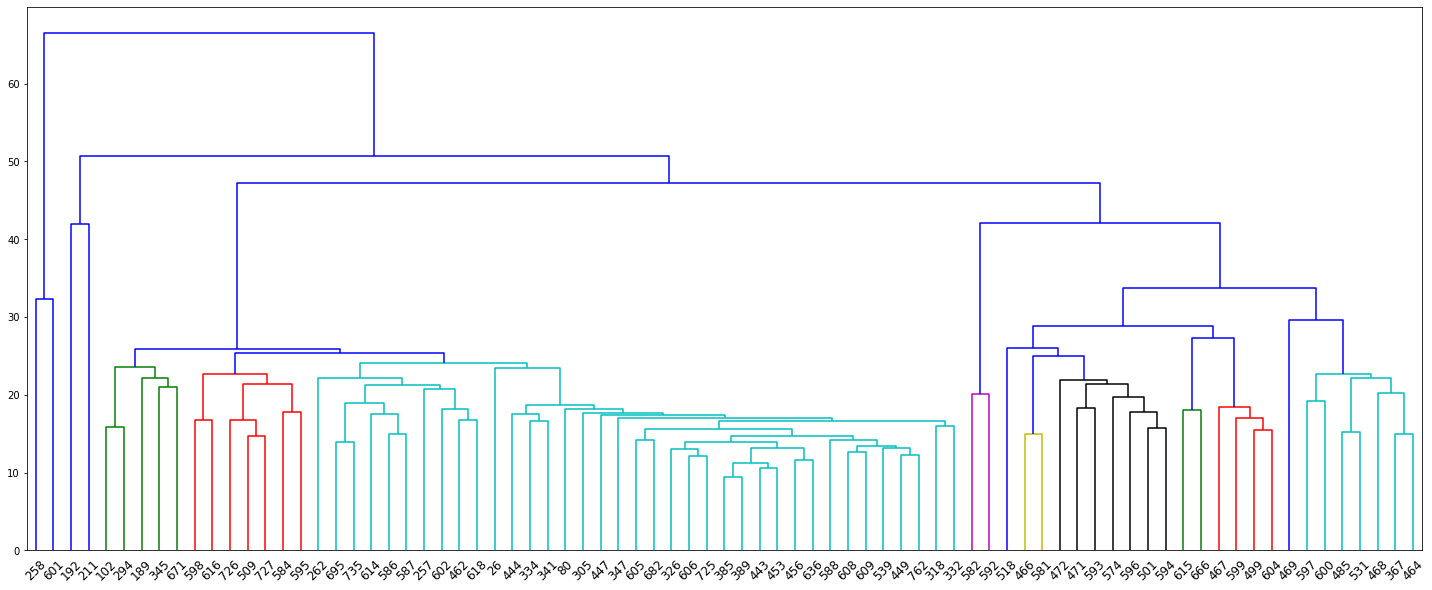

In [32]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
import scipy.spatial.distance as ssd
import sklearn
from sklearn.metrics.pairwise import nan_euclidean_distances

# Retrieve clusters using fcluster 
d = nan_euclidean_distances(clustering_data_zscores_only.drop(columns=['Position']))

L_complete = sch.linkage(d, method='complete')
L_single = sch.linkage(d, method='single')
L_average = sch.linkage(d, method='average')
L_ward = sch.linkage(d, method='ward')

# Plot dendrogram
plt.figure(figsize=(25, 10))
dendrogram(L_average, truncate_mode="level", p=20, color_threshold=25, labels=clustering_data_by_position['Position'].values)
plt.xticks(rotation=45, fontsize=12)
#plt.show()

plt.savefig('dendogram.svg', format='svg')


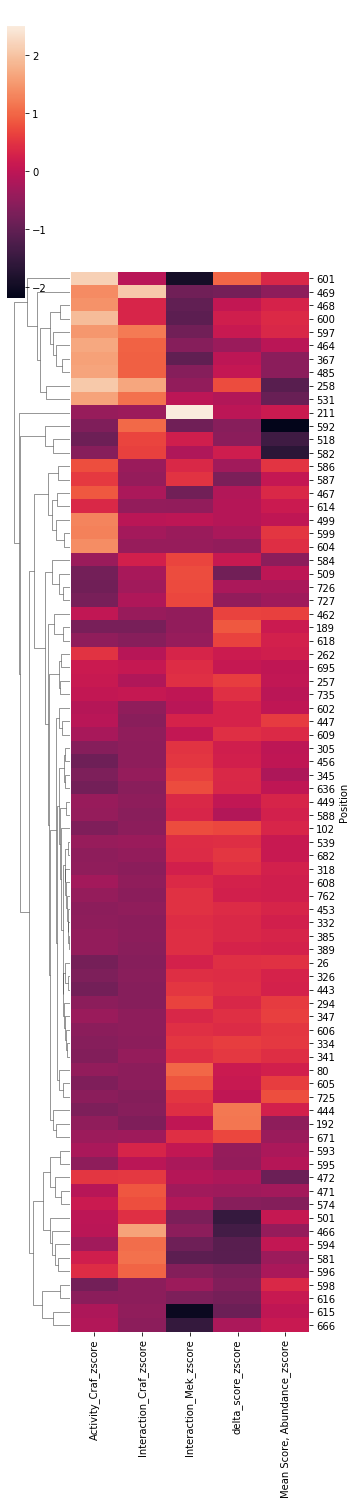

In [31]:
sns.clustermap((clustering_data_by_position.set_index('Position')),
    #cmap="BuPu",
    #vmax = 3.5,
    #vmin = -3.5,
    figsize=(5,21),
    col_cluster = False,
    method = 'average'
)